In [88]:
import warnings
warnings.filterwarnings(action='ignore')

import sys
import seaborn as sb
from math import sqrt
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import *
from statannotations.Annotator import Annotator

In [2]:
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["axes.unicode_minus"] = False

- 독립표본 T-검정
  - 서로 다른 두 그룹 간의 평균의 차이가 유의미한지 검정
  - 양측 데이터의 정규성과 등분산성이 충족되어야 함

In [3]:
df = pd.read_excel("./data/styptic.xlsx")

In [4]:
df.head()

,B,G
0,8.8,9.9
1,8.9,10.0
2,8.4,9.0
3,7.9,11.1
4,8.2,9.8


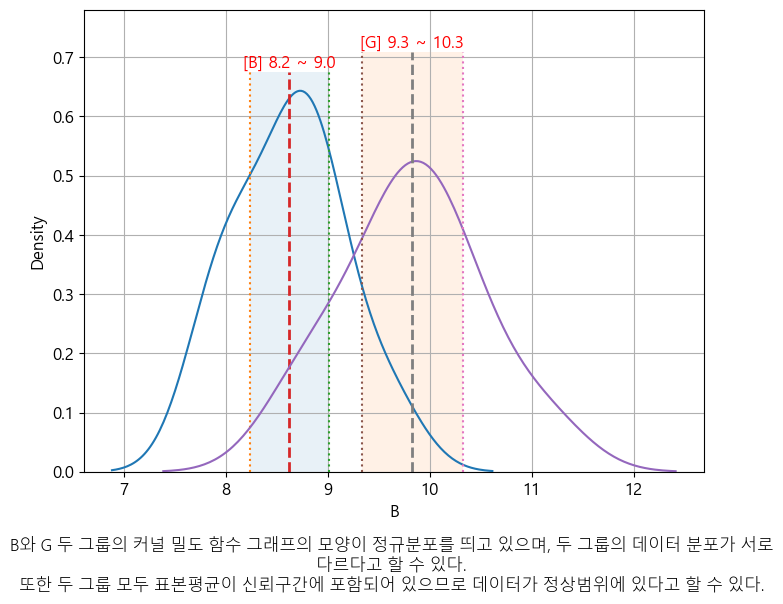

In [5]:
plt.figure()

for c in df.columns:
    #print(c)
    
    data = df[c]                                # 데이터만 추출
    max = data.max()                                # 최대값
    clevel = 0.95                                   # 신뢰수준
    dof = len(data) - 1                             # 자유도
    sample_mean = data.mean()                       # 표본평균
    sample_std = data.std(ddof=1)                   # 표본표준편차
    sample_std_error = sample_std / sqrt(len(data)) # 표본표준오차
    
    # 신뢰구간
    cmin, cmax = t.interval(clevel, dof, loc=sample_mean, scale=sample_std_error)

    sb.kdeplot(data=data)

    xmin, xmax, ymin, ymax = plt.axis()

    # 신뢰구간 그리기
    plt.plot([cmin, cmin], [ymin, ymax], linestyle=':')
    plt.plot([cmax, cmax], [ymin, ymax], linestyle=':')
    plt.fill_between([cmin, cmax], y1=ymin, y2=ymax, alpha=0.1)

    # 평균 그리기
    plt.plot([sample_mean, sample_mean], [ymin, ymax], linestyle='--', linewidth=2)

    plt.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 12, "color": "red"})

plt.ylim(ymin, ymax*1.1)

txt = """B와 G 두 그룹의 커널 밀도 함수 그래프의 모양이 정규분포를 띄고 있으며, 두 그룹의 데이터 분포가 서로 다르다고 할 수 있다.
또한 두 그룹 모두 표본평균이 신뢰구간에 포함되어 있으므로 데이터가 정상범위에 있다고 할 수 있다."""

plt.figtext(0.51, 0, txt, wrap=True,
            verticalalignment="top", horizontalalignment="center",
            fontdict={"size": 12, "weight": "light"})

plt.grid()
plt.show()
plt.close()

In [6]:
for c in df.columns:
    s, p = normaltest(df[c])
    print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(c, s, p, p >= 0.05))

[B] statistic: 0.083, p-value: 0.959, 정규성 충족 여부: True
[G] statistic: 0.201, p-value: 0.904, 정규성 충족 여부: True


In [7]:
normal_dist = True      # 정규성 만족 여부
data = df.copy()    # 원본 데이터 복사
fields = list(map(lambda x: data[x], data.columns))

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*fields)
else:
    n = "Levene"
    s, p = levene(*fields)
    
print("{0} 검정: statistic: {1:.3f}, p-value: {2:.3f}, 등분산성 충족 여부: {3}".format(n, s, p, p >= 0.05))

Bartlett 검정: statistic: 0.556, p-value: 0.456, 등분산성 충족 여부: True


- T-검정 (two-sided)
  - 귀무가설 : 두 그룹간 평균의 차이가 없다.
  - 대립가설 : 두 그룹간 평균의 차이가 있다.

In [8]:
s, p = ttest_ind(df['B'], df['G'], alternative = 'two-sided')
s, p

(-4.34966403941523, 0.00038617404190428997)

- T-검정 (greater)
  - 귀무가설 : B 그룹의 평균이 G그룹의 평균보다 크지 않다.
  - 대립가설 : B 그룹의 평균이 G그룹의 평균보다 크다.

In [9]:
s, p = ttest_ind(df['B'], df['G'], alternative = 'greater')
s, p

(-4.34966403941523, 0.9998069129790479)

- alternative별 대립가설은 첫번째 파라미터를 기준으로 칭한다

- T-검정 (less)
  - 귀무가설 : B 그룹의 평균이 G그룹의 평균보다 작지 않다.
  - 대립가설 : B 그룹의 평균이 G그룹의 평균보다 작다.

In [10]:
s, p = ttest_ind(df['B'], df['G'], alternative = 'less')
s, p

(-4.34966403941523, 0.00019308702095214498)

- 결론 : B 그룹의 지혈시간 평균이 G 그룹보다 작으므로 지혈제 B의 효능이 더 좋다

- 가설검정 시각화 : statannotations 패키지의 Annotator 클래스로 구현 가능
  - hue 파라미터를 쓸 수 있는 형태로 데이터 재배치가 필요

In [11]:
df_2 = pd.melt(df, var_name = 'group', value_name = 'value')
df_2.head()

,group,value
0,B,8.8
1,B,8.9
2,B,8.4
3,B,7.9
4,B,8.2


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

B vs. G: t-test independent samples, P_val:3.862e-04 t=-4.350e+00


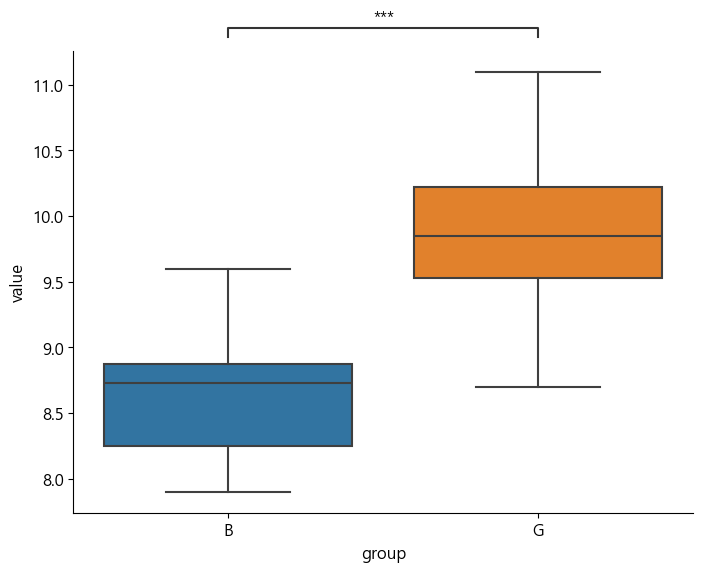

In [12]:
plt.figure()
ax = sb.boxplot(data=df_2, x='group', y='value')

annotator = Annotator(ax, data=df_2, x='group', y='value', pairs=[('B', 'G')])
annotator.configure(test='t-test_ind', text_format='star', loc='outside')
annotator.apply_and_annotate()

sb.despine()
plt.show()
plt.close()

- 귀무가설 기각 여부를 결정하는 p-value의 기준은 0.05 **이하**로 판별

B vs. G: t-test independent samples, P_val:3.862e-04 t=-4.350e+00


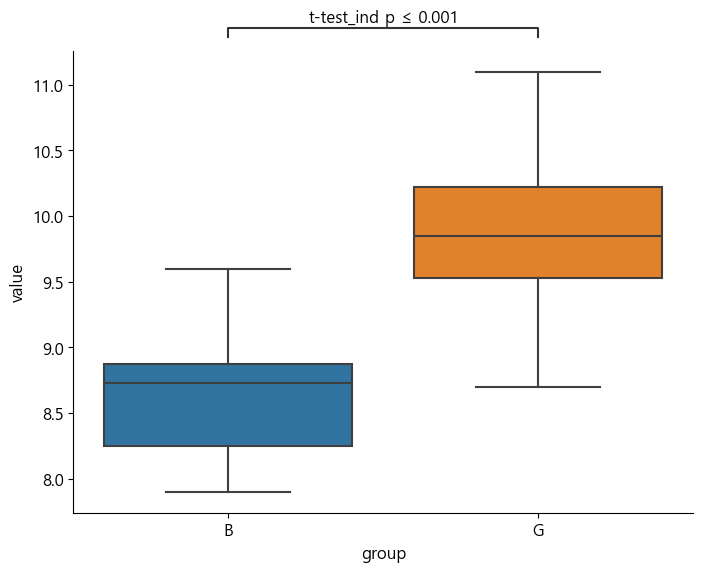

In [13]:
plt.figure()
ax = sb.boxplot(data=df_2, x='group', y='value')

annotator = Annotator(ax, data=df_2, x='group', y='value', pairs=[('B', 'G')])
annotator.configure(test='t-test_ind', text_format='simple', loc='outside')
annotator.apply_and_annotate()

sb.despine()
plt.show()
plt.close()

B vs. G: t-test independent samples, P_val:3.862e-04 t=-4.350e+00


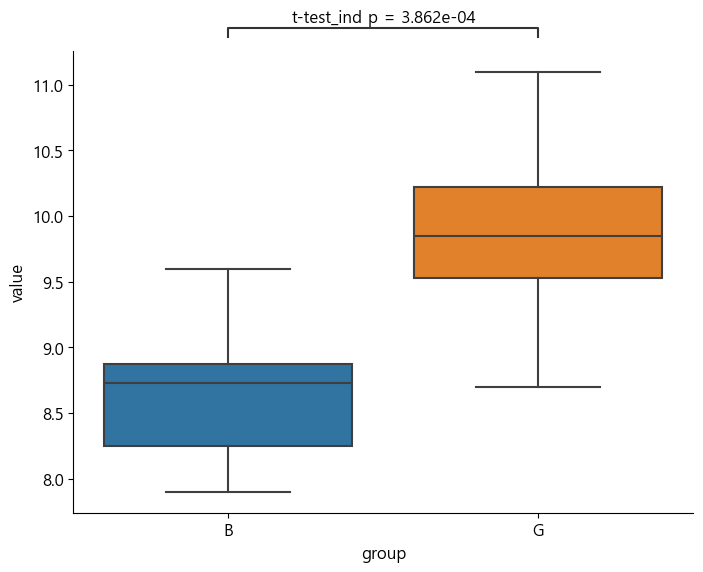

In [14]:
plt.figure()
ax = sb.boxplot(data=df_2, x='group', y='value')

annotator = Annotator(ax, data=df_2, x='group', y='value', pairs=[('B', 'G')])
annotator.configure(test='t-test_ind', text_format='full', loc='outside')
annotator.apply_and_annotate()

sb.despine()
plt.show()
plt.close()

- 인공심장 데이터

In [17]:
df2 = pd.read_excel("./data/heatrate.xlsx")

In [18]:
df2.head()

,그룹1,그룹2
0,3.84,3.97
1,2.60,2.50
2,1.19,2.70
3,2.00,3.36
4,6.20,3.55


In [42]:
normal_dist = True      # 정규성 만족 여부
data = df2.copy()    # 원본 데이터 복사
fields = list(map(lambda x: data[x], data.columns))

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*fields)
else:
    n = "Levene"
    s, p = levene(*fields)

print("{0} 검정: statistic: {1:.3f}, p-value: {2:.3f}, 등분산성 충족 여부: {3}".format(n, s, p, p >= 0.05))

Bartlett 검정: statistic: 8.029, p-value: 0.005, 등분산성 충족 여부: False


In [43]:
s, p = ttest_ind(df2['그룹1'], df2['그룹2'], alternative='two-sided', equal_var=False)
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p < 0.05 else "귀무")

'statistic: 0.163, p-value: 0.874, 귀무가설 채택'

In [47]:
s, p = ttest_ind(df2['그룹1'], df2['그룹2'], alternative='less', equal_var=False)
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p < 0.05 else "귀무")

'statistic: 0.163, p-value: 0.563, 귀무가설 채택'

In [46]:
s, p = ttest_ind(df2['그룹1'], df2['그룹2'], alternative='greater', equal_var=False)
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p < 0.05 else "귀무")

'statistic: 0.163, p-value: 0.437, 귀무가설 채택'

In [48]:
df2_2 = pd.melt(df2, var_name='group', value_name='value')
df2_2

,group,value
0,그룹1,3.84
1,그룹1,2.60
2,그룹1,1.19
3,그룹1,2.00
4,그룹1,6.20
5,그룹1,0.96
6,그룹1,5.50
7,그룹1,3.18
8,그룹2,3.97
9,그룹2,2.50


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

그룹1 vs. 그룹2: t-test independent samples, P_val:8.726e-01 t=1.633e-01


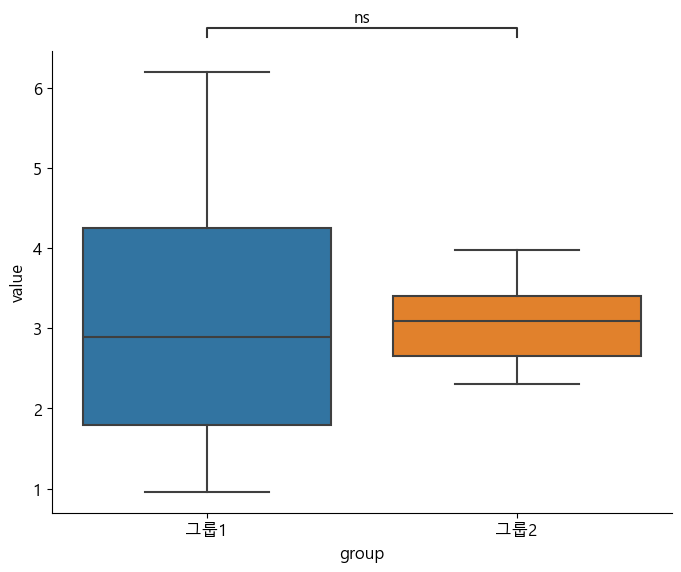

In [49]:
config = {
    "data": df2_2,
    "x": "group",
    "y": "value",
    "pairs": [("그룹1", "그룹2")],
    "test": "t-test_ind",
    "text_format": "star",
    "loc": "outside"
}

plt.figure()
ax = sb.boxplot(data=config['data'], x=config['x'], y=config['y'])
ax.get_xaxis().axis_name

annotator = Annotator(ax, data=config['data'], x=config['x'], y=config['y'], pairs=config['pairs'])
annotator.configure(test=config['test'], text_format=config['text_format'], loc=config['loc'])
annotator.apply_and_annotate()

sb.despine()
plt.show()
plt.close()

- 요약 그래프의 'ns' : 귀무가설 채택

- 대응 표본 t-검정
  - 하나의 표본에 대한 검정
  - 어떤 작용에 대한 Before, After의 차이

In [86]:
df3 = pd.read_excel("./data/deer.xlsx", index_col="사슴")
df3.head()

,앞다리,뒷다리
사슴,,
1,138,142
2,136,140
3,147,144
4,139,144
5,143,142


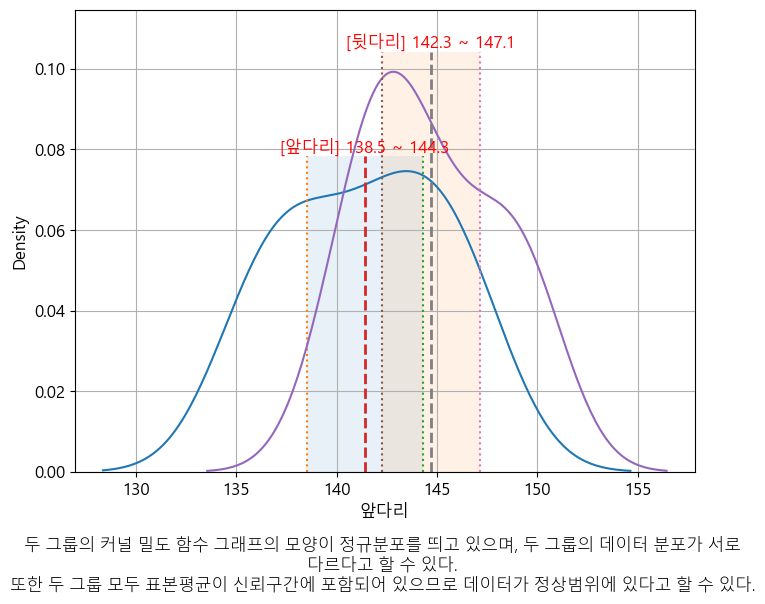

In [89]:
plt.figure()

for c in df3.columns:
    #print(c)

    data = df3[c]                                # 데이터만 추출
    max = data.max()                                # 최대값
    clevel = 0.95                                   # 신뢰수준
    dof = len(data) - 1                             # 자유도
    sample_mean = data.mean()                       # 표본평균
    sample_std = data.std(ddof=1)                   # 표본표준편차
    sample_std_error = sample_std / sqrt(len(data)) # 표본표준오차

    # 신뢰구간
    cmin, cmax = t.interval(clevel, dof, loc=sample_mean, scale=sample_std_error)

    sb.kdeplot(data=data)

    xmin, xmax, ymin, ymax = plt.axis()

    # 신뢰구간 그리기
    plt.plot([cmin, cmin], [0, ymax], linestyle=':')
    plt.plot([cmax, cmax], [0, ymax], linestyle=':')
    plt.fill_between([cmin, cmax], y1=0, y2=ymax, alpha=0.1)

    # 평균 그리기
    plt.plot([sample_mean, sample_mean], [0, ymax], linestyle='--', linewidth=2)

    plt.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 12, "color": "red"})

txt = """두 그룹의 커널 밀도 함수 그래프의 모양이 정규분포를 띄고 있으며, 두 그룹의 데이터 분포가 서로 다르다고 할 수 있다.
또한 두 그룹 모두 표본평균이 신뢰구간에 포함되어 있으므로 데이터가 정상범위에 있다고 할 수 있다."""

plt.figtext(0.51, 0, txt, wrap=True,
            verticalalignment="top", horizontalalignment="center",
            fontdict={"size": 12, "weight": "light"})

plt.ylim(0, ymax*1.1)
plt.grid()
plt.show()
plt.close()


In [90]:
for c in df3.columns:
    s, p = normaltest(df3[c])
    print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(c, s, p, p >= 0.05))

[앞다리] statistic: 1.824, p-value: 0.402, 정규성 충족 여부: True
[뒷다리] statistic: 1.377, p-value: 0.502, 정규성 충족 여부: True


In [91]:
normal_dist = True      # 정규성 만족 여부
data = df3.copy()    # 원본 데이터 복사
fields = list(map(lambda x: data[x], data.columns))

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*fields)
else:
    n = "Levene"
    s, p = levene(*fields)

print("{0} 검정: statistic: {1:.3f}, p-value: {2:.3f}, 등분산성 충족 여부: {3}".format(n, s, p, p > 0.05))

Bartlett 검정: statistic: 0.247, p-value: 0.619, 등분산성 충족 여부: True


In [94]:
s, p = ttest_rel(df3['앞다리'], df3['뒷다리'], alternative='two-sided')
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: -3.414, p-value: 0.008, 대립가설 채택'

- 귀무가설 : 앞다리 길이 평균과 뒷다리 길이 평균은 같다.
- 대립가설 : 앞다리 길이 평균과 뒷다리 길이 평균은 다르다.

In [92]:
s, p = ttest_rel(df3['앞다리'], df3['뒷다리'], alternative='less')
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: -3.414, p-value: 0.004, 대립가설 채택'

- 귀무가설 : 앞다리 길이 평균은 뒷다리 길이 평균보다 작지 않다.
- 대립가설 : 앞다리 길이 평균은 뒷다리 길이 평균보다 작다.

In [93]:
s, p = ttest_rel(df3['앞다리'], df3['뒷다리'], alternative='greater')
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: -3.414, p-value: 0.996, 귀무가설 채택'

- 귀무가설 : 앞다리 길이 평균은 뒷다리 길이 평균보다 길지 않다.
- 대립가설 : 앞다리 길이 평균은 뒷다리 길이 평균보다 길다.

In [96]:
df3_2 = pd.melt(df3, var_name='group', value_name='value')
df3_2.head()

,group,value
0,앞다리,138
1,앞다리,136
2,앞다리,147
3,앞다리,139
4,앞다리,143


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

앞다리 vs. 뒷다리: t-test paired samples, P_val:7.703e-03 t=-3.414e+00


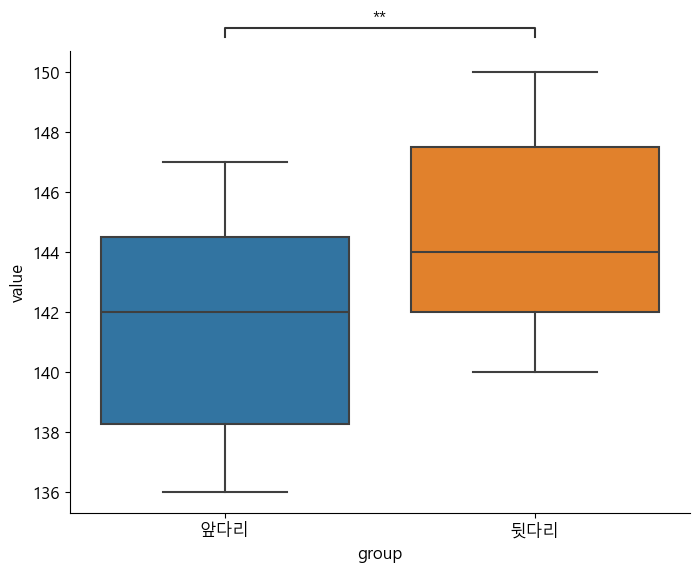

In [97]:
config = {
    "data": df3_2,
    "x": "group",
    "y": "value",
    "pairs": [("앞다리", "뒷다리")],
    "test": "t-test_paired", # t-test_ind, t-test_paired, t-test_welch, Mann-Whitney, Mann-Whitney-gt, Mann-Whitney-ls, Levene, Wilcoxon, Kruskal
    "text_format": "star", # full, simple, star
    "loc": "outside" # outside, inside
}

plt.figure()
ax = sb.boxplot(data=config['data'], x=config['x'], y=config['y'])
ax.get_xaxis().axis_name

annotator = Annotator(ax, data=config['data'], x=config['x'], y=config['y'], pairs=config['pairs'])
annotator.configure(test=config['test'], text_format=config['text_format'], loc=config['loc'])
annotator.apply_and_annotate()

sb.despine()
plt.show()
plt.close()

- 자동차 첨가제 데이터

In [98]:
df4 = pd.read_excel("./data/oil.xlsx")

In [99]:
df4.head()

,그룹A,그룹B
0,13.2,11.8
1,13.1,13.9
2,16.3,12.1
3,14.9,10.5
4,14.2,9.3


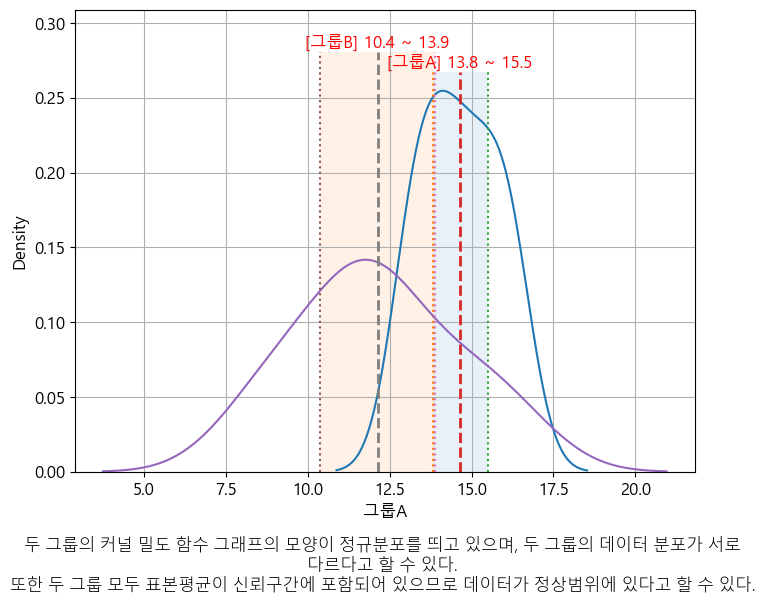

In [100]:
plt.figure()

for c in df4.columns:
    #print(c)

    data = df4[c]                                # 데이터만 추출
    max = data.max()                                # 최대값
    clevel = 0.95                                   # 신뢰수준
    dof = len(data) - 1                             # 자유도
    sample_mean = data.mean()                       # 표본평균
    sample_std = data.std(ddof=1)                   # 표본표준편차
    sample_std_error = sample_std / sqrt(len(data)) # 표본표준오차

    # 신뢰구간
    cmin, cmax = t.interval(clevel, dof, loc=sample_mean, scale=sample_std_error)

    sb.kdeplot(data=data)

    xmin, xmax, ymin, ymax = plt.axis()

    # 신뢰구간 그리기
    plt.plot([cmin, cmin], [ymin, ymax], linestyle=':')
    plt.plot([cmax, cmax], [ymin, ymax], linestyle=':')
    plt.fill_between([cmin, cmax], y1=0, y2=ymax, alpha=0.1)

    # 평균 그리기
    plt.plot([sample_mean, sample_mean], [0, ymax], linestyle='--', linewidth=2)

    plt.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 12, "color": "red"})

plt.ylim(ymin, ymax*1.1)

txt = """두 그룹의 커널 밀도 함수 그래프의 모양이 정규분포를 띄고 있으며, 두 그룹의 데이터 분포가 서로 다르다고 할 수 있다.
또한 두 그룹 모두 표본평균이 신뢰구간에 포함되어 있으므로 데이터가 정상범위에 있다고 할 수 있다."""

plt.figtext(0.51, 0, txt, wrap=True,
            verticalalignment="top", horizontalalignment="center",
            fontdict={"size": 12, "weight": "light"})

plt.grid()
plt.show()
plt.close()


In [101]:
for c in df4.columns:
    s, p = normaltest(df4[c])
    print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(c, s, p, p > 0.05))

[그룹A] statistic: 1.804, p-value: 0.406, 정규성 충족 여부: True
[그룹B] statistic: 0.151, p-value: 0.927, 정규성 충족 여부: True


In [102]:
normal_dist = True      # 정규성 만족 여부
data = df4.copy()    # 원본 데이터 복사
fields = list(map(lambda x: data[x], data.columns))

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*fields)
else:
    n = "Levene"
    s, p = levene(*fields)

print("{0} 검정: statistic: {1:.3f}, p-value: {2:.3f}, 등분산성 충족 여부: {3}".format(n, s, p, p > 0.05))

Bartlett 검정: statistic: 4.273, p-value: 0.039, 등분산성 충족 여부: False


- 등분산성 불만족
  - 이에 대한 대응표본 검정은 Mann-Whitney U 검정을 실행함

In [103]:
s, p = mannwhitneyu(df4['그룹A'], df4['그룹B'], alternative='two-sided')
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 81.000, p-value: 0.021, 대립가설 채택'

- 귀무가설 : 그룹A와 그룹B의 평균 주행거리는 다르지 않다.
- 대립가설 : 그룹A와 그룹B의 평균 주행거리는 다르다.

In [104]:
s, p = mannwhitneyu(df4['그룹A'], df4['그룹B'], alternative='greater')
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 81.000, p-value: 0.010, 대립가설 채택'

- 귀무가설 : 그룹A의 주행거리가 그룹B의 주행거리보다 길지 않다.
- 대립가설 : 그룹A의 주행거리가 그룹B의 주행거리보다 길다.

In [105]:
s, p = mannwhitneyu(df4['그룹A'], df4['그룹B'], alternative='less')
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 81.000, p-value: 0.991, 귀무가설 채택'

- 귀무가설 : 그룹A의 주행거리가 그룹B의 주행거리보다 짧지 않다.
- 대립가설 : 그룹A의 주행거리가 그룹B의 주행거리보다 짧다.

In [107]:
df4_2 = pd.melt(df4, var_name='group', value_name='value')
df4_2.head()

,group,value
0,그룹A,13.2
1,그룹A,13.1
2,그룹A,16.3
3,그룹A,14.9
4,그룹A,14.2


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

그룹A vs. 그룹B: Mann-Whitney-Wilcoxon test two-sided, P_val:2.099e-02 U_stat=8.100e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

그룹A vs. 그룹B: Mann-Whitney-Wilcoxon test smaller, P_val:9.914e-01 U_stat=8.100e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

그룹A vs. 그룹B: Mann-Whitney-Wilcoxon test greater, P_val:1.049e-02 U_stat=8.100e+01


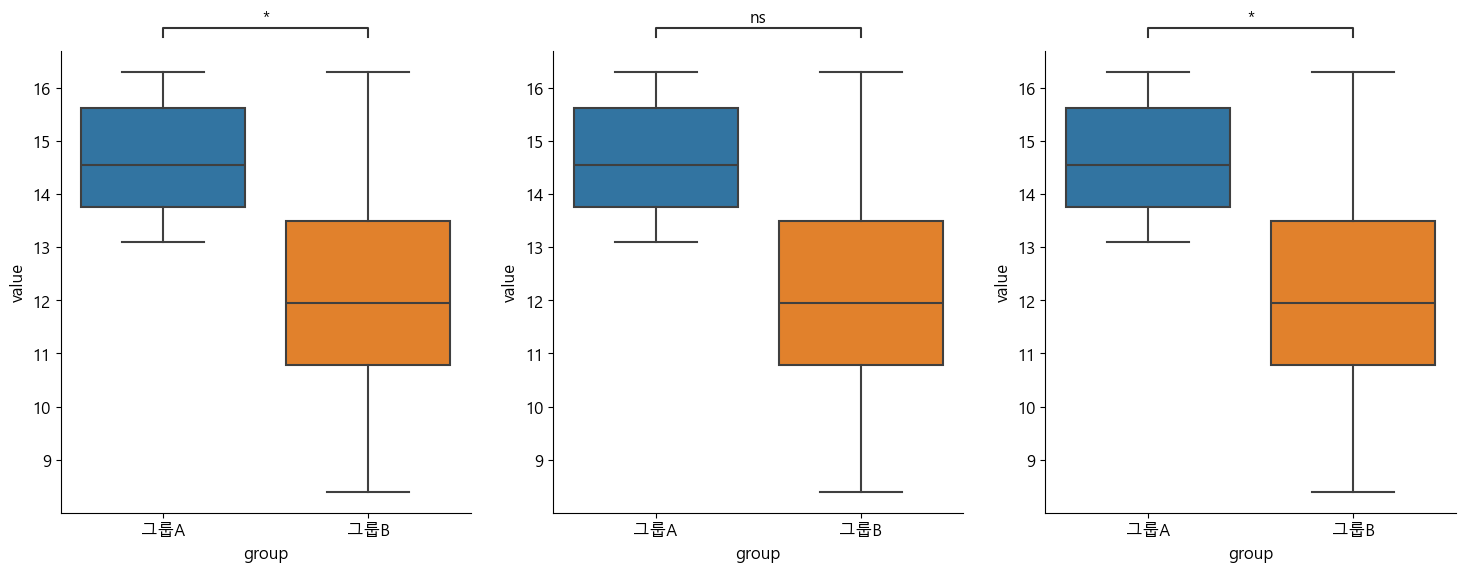

In [109]:
test = ['Mann-Whitney', 'Mann-Whitney-ls', 'Mann-Whitney-gt']

config = {
    "data": df4_2,
    "x": "group",
    "y": "value",
    "pairs": [("그룹A", "그룹B")],
    "test": None,
    "text_format": "star",
    "loc": "outside"
}

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

for i, v in enumerate(ax):
    config['test'] = test[i]

    k = sb.boxplot(ax=v, data=config['data'], x=config['x'], y=config['y'])

    annotator = Annotator(k, data=config['data'], x=config['x'], y=config['y'], pairs=config['pairs'])
    annotator.configure(test=config['test'], text_format=config['text_format'], loc=config['loc'])
    annotator.apply_and_annotate()

    sb.despine(ax=v)

plt.show()
plt.close()


- 마케팅에서는 T-test를 A/B Test라고 부름